<a href="https://colab.research.google.com/github/hassaanmuzammil/Neural-Style-Transfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Imports

In [ ]:
import torch
import torch.nn as nn #building block to create and train NN
import torch.nn.functional as F #build network layers
import torch.optim as optim #optimized gradient descent

import torchvision.transforms as transforms #transforms images to tensors
import torchvision.models as models #pre-trained models

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Mount drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Load images from drive and visualize the style and content images

In [ ]:
def image_loader(img_dir): #load image from file as numpy array
    img = plt.imread(img_dir)
    return img 
  
content_dir = '/content/gdrive/My Drive/79082.jpg'
style_dir = '/content/gdrive/My Drive/79086.jpg'

content_img = image_loader(content_dir)
style_img = image_loader(style_dir)

Text(0.5, 1.0, 'Content Image')

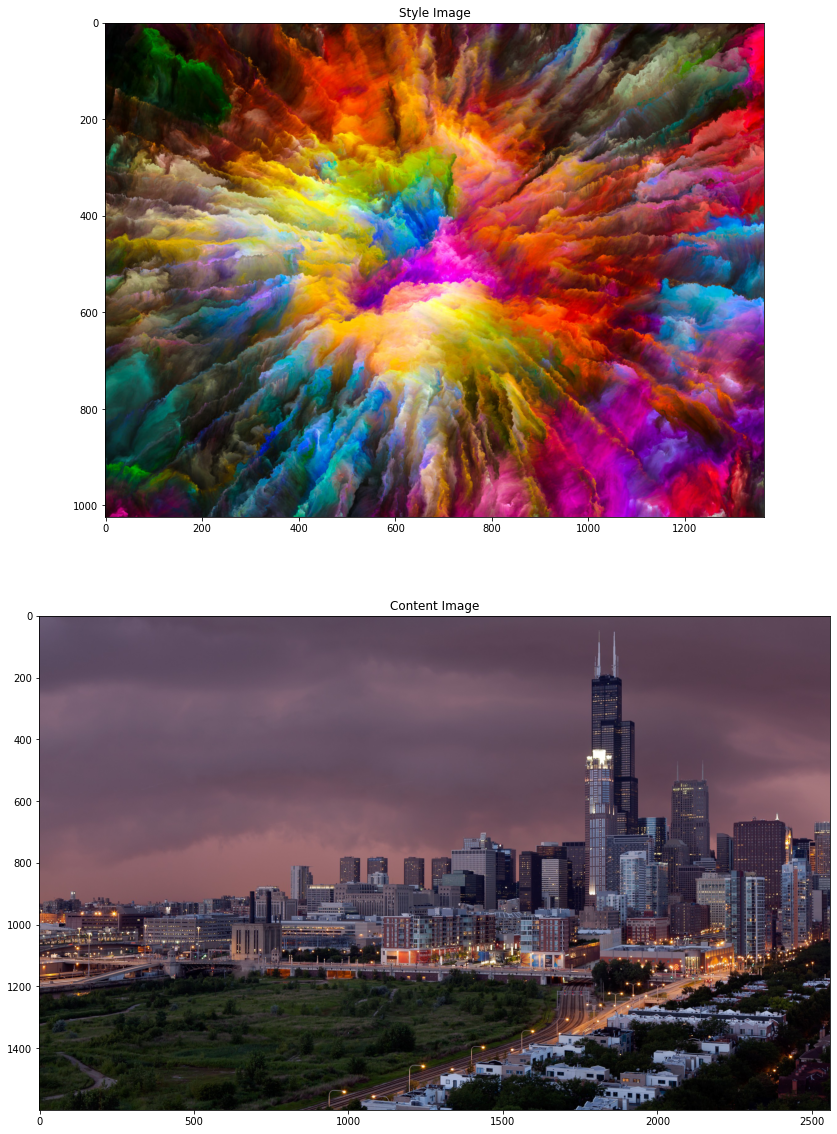

In [ ]:
fig = plt.figure(figsize=(20,20))

ax = fig.add_subplot(2,1,1)
ax.imshow(style_img)
ax.set_title('Style Image')

ax = fig.add_subplot(2,1,2)
ax.imshow(content_img)
ax.set_title('Content Image')

In [ ]:
print(style_img.shape)
print(content_img.shape)

(1024, 1365, 3)
(1600, 2560, 3)


Process image 
(loader/unloader functions)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((512,512)),
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), 
                        (0.229, 0.224, 0.225))])

def image_loader(img_dir): # PIL image to 4d tensor (B,C,H,W)
    image = Image.open(img_dir)
    image = transform(image).unsqueeze(0)
    return image.to(device, torch.float)

def image_unloader(tensor): #4d tensor back to PIL image RGB
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = image.detach().numpy().transpose(1,2,0)
    image = image * np.array((0.229, 0.224, 0.225)) + np.array((0.485, 0.456, 0.406))
    return image


Plot processed Style and Content Images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, 'Content Image')

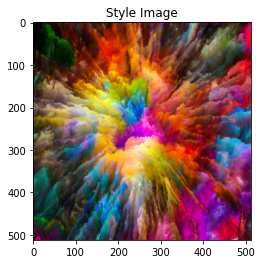

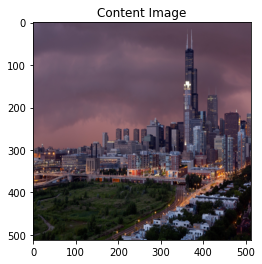

In [ ]:
style = image_loader(style_dir)
content = image_loader(content_dir)

plt.figure()
img = image_unloader(style)
plt.imshow(img)
plt.title('Style Image')

img = image_unloader(content)
plt.figure()
plt.imshow(img)
plt.title('Content Image')


Load the vgg-19 model

In [ ]:
vgg = models.vgg19(pretrained=True).features.to(device).eval()

for param in vgg.parameters():
    param.requires_grad_(False)

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


Visualize model structure & layers 

In [ ]:
#for name, layer in model.named_modules():
#    if isinstance(layer, nn.Conv2d):
#        print(name,':',layer)
        
for name,layer in vgg._modules.items():
    print(name,':',layer)

0 : Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
1 : ReLU(inplace=True)
2 : Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
3 : ReLU(inplace=True)
4 : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
5 : Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
6 : ReLU(inplace=True)
7 : Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
8 : ReLU(inplace=True)
9 : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
10 : Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
11 : ReLU(inplace=True)
12 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
13 : ReLU(inplace=True)
14 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
15 : ReLU(inplace=True)
16 : Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
17 : ReLU(inplace=True)
18 : MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)


Function to extract features of image from specific layers

In [ ]:
def get_features(image, model, layers=None):
    """ Run an image forward through a model and get the features for 
        a set of layers. Default layers for VGG-19
    """
    
    if layers is None:
        layers = {'0': 'conv1_1',
                  '5': 'conv2_1', 
                  '10': 'conv3_1', 
                  '19': 'conv4_1',
                  '21': 'conv4_2',  ## content representation
                  '28': 'conv5_1'}
        
    features = {}
    x = image
    # model._modules is a dictionary holding each module in the model
    for name, layer in model._modules.items():
        x = layer(x)
        if name in layers:
            features[layers[name]] = x
            
    return features

Define the content-generated cost function.

In [ ]:
def compute_content_cost(a_C,a_G):
    """
    Computes the content cost
    
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar that you compute using equation 1 above.
    """
    #Retrieve dimensions 
    m, n_H, n_W, n_C = list(a_G.shape) 
    
    # Reshape the images to have them of shape (n_C, n_H*n_W)
    a_C_unrolled = torch.reshape(a_C, shape=[m, n_H * n_W, n_C])
    a_G_unrolled = torch.reshape(a_G, shape=[m, n_H * n_W, n_C])
    
    #Cost function
    J_content = (1/(4*n_H*n_C*n_W)) * torch.sum(torch.square(torch.sub(a_C_unrolled, a_G_unrolled)))
    
    return J_content

Calculate the gram matrix of a tensor

In [ ]:
def gram_matrix(tensor):

    # get the batch_size, depth, height, and width of the Tensor
    _, c, h, w = tensor.size()
    
    # reshape so we're multiplying the features for each channel
    tensor = tensor.view(c, h * w)
    
    # calculate the gram matrix
    gram = torch.mm(tensor, tensor.t())
    
    return gram

Compute generated-style cost for one layer

In [ ]:
def compute_layer_style_cost(a_S, a_G, layer, coef = 0.2):
    """
    Arguments:
    a_S -- hidden layer activations representing style of the image S 
    a_G -- hidden layer activations representing style of the image G
    
    Returns: 
    J_style_layer -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    #Retrieve dimensions 
    _, c, h, w = list(a_G.shape)

    # Computing gram_matrices for both images S and G
    GS = gram_matrix(a_S) 
    GG = gram_matrix(a_G)

    # Computing the loss
    J_style_layer = (1/(4*c**2*h**2*w**2)) * torch.sum(torch.square(torch.sub(GS,GG)))
    
    J_style_layer = J_style_layer * coef

    return J_style_layer

Add up the style-generated cost for all the defined layers

In [ ]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

def compute_style_cost(style_features,generated_features,STYLE_LAYERS):
    """
    Computes the overall style cost from several chosen layers
    
    Arguments:
    STYLE_LAYERS -- A python list containing:
                        - the names of the layers we would like to extract style from
    
    Returns: 
    J_style -- tensor representing a scalar value, style cost defined above by equation (2)
    """
    
    # initialize the overall style cost
    J_style = 0

    for layer_name, coef in STYLE_LAYERS:

        #Features of given layer
        a_S = style_features[layer_name]
        a_G = generated_features[layer_name]
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S,a_G,layer_name,coef)
        
        J_style = J_style_layer + J_style

    return J_style

Total Cost Function

In [ ]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
    """
    Computes the total cost function
    
    Arguments:
    J_content -- content cost coded above
    J_style -- style cost coded above
    alpha -- hyperparameter weighting the importance of the content cost
    beta -- hyperparameter weighting the importance of the style cost
    
    Returns:
    J -- total cost as defined by the formula above.
    """

    J = alpha * J_content + beta * J_style
    
    return J

Initialize the generated image to be same as the content image

In [ ]:
# create a third "generated" image and prep it for change
# it is a good idea to start of with the generated as a copy of our *content* image
# then iteratively change its style
generated = content.clone().requires_grad_(True).to(device)


In [ ]:
def generate_noise_image(content_image, noise_ratio = 0.6):
    """
    Generates a noisy image by adding random noise to the content_image
    """
    
    # Generate a random noise_image
    noise_image = np.random.uniform(-20, 20, (512, 512, 3)).astype('float32')
    
    # Set the input_image to be a weighted average of the content_image and a noise_image
    input_image = noise_image * noise_ratio + content_image * (1 - noise_ratio)
    
    return input_image

#generate_img = generate_noise_image(content_img)
#generated = image_loader(generate_img)

Test Case: Compute the total cost initially

In [ ]:
# get content and style features only once before training
content_features = get_features(content, vgg)
style_features = get_features(style, vgg)
generated_features = get_features(generated, vgg)

# calculate the gram matrices for each layer of our style representation
style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features} 

#features of conv4_2 layer when content image is passed through model
a_C = content_features['conv4_2']

#features of conv4_2 layer when generated image is passed through model
a_G = generated_features['conv4_2']

#cost computation
J_content = compute_content_cost(a_C,a_G)
J_style = compute_style_cost(style_features,generated_features,STYLE_LAYERS)

J = total_cost(J_content, J_style, 10 , 40)
print('Total Cost', J.item())

Total Cost 38.040157318115234


Define optimizer, learning rate, epochs

In [ ]:
# iteration hyperparameters
optimizer = optim.Adam([generated], lr=0.008)
epochs = 500
show_every = 50

Train the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  50   Total loss:  4384.15478515625


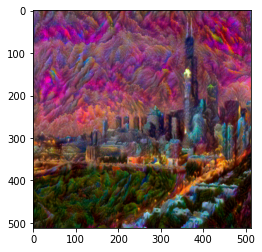

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  100   Total loss:  2568.43359375


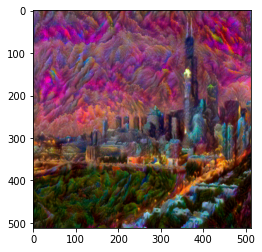

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  150   Total loss:  2121.30126953125


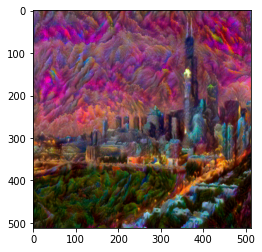

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  200   Total loss:  1897.037841796875


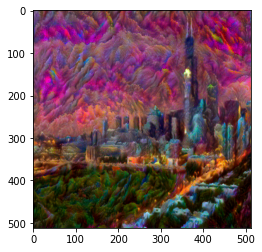

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  250   Total loss:  1754.931884765625


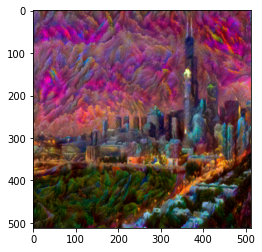

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  300   Total loss:  1653.7828369140625


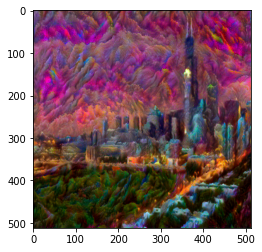

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  350   Total loss:  1576.503662109375


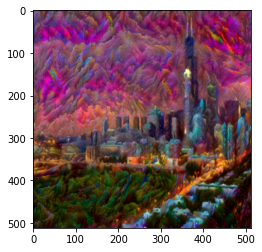

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  400   Total loss:  1514.6263427734375


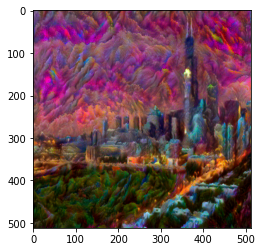

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Epoch:  450   Total loss:  1463.2044677734375


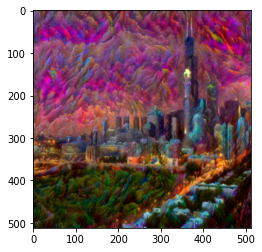

In [ ]:
train_loss = []

for i in range(1,epochs):
  #get generated features for different layers
  generated_features = get_features(generated, vgg)

  #content cost function
  a_G = generated_features['conv4_2']
  J_content = compute_content_cost(a_C,a_G)

  #style cost function
  J_style = compute_style_cost(style_features,generated_features,STYLE_LAYERS)
  
  #total cost
  J = total_cost(J_content, J_style, 1 , 1000000)

  #update generated image
  optimizer.zero_grad()
  J.backward(retain_graph=True)
  optimizer.step()
  train_loss.append(J.item())

  #display intermediate images and print the total loss
  if  i % show_every == 0:
        print('Epoch: ', i, '  Total loss: ', J.item())
        plt.imshow(image_unloader(generated))
        plt.show()
  
               

RESULTS!

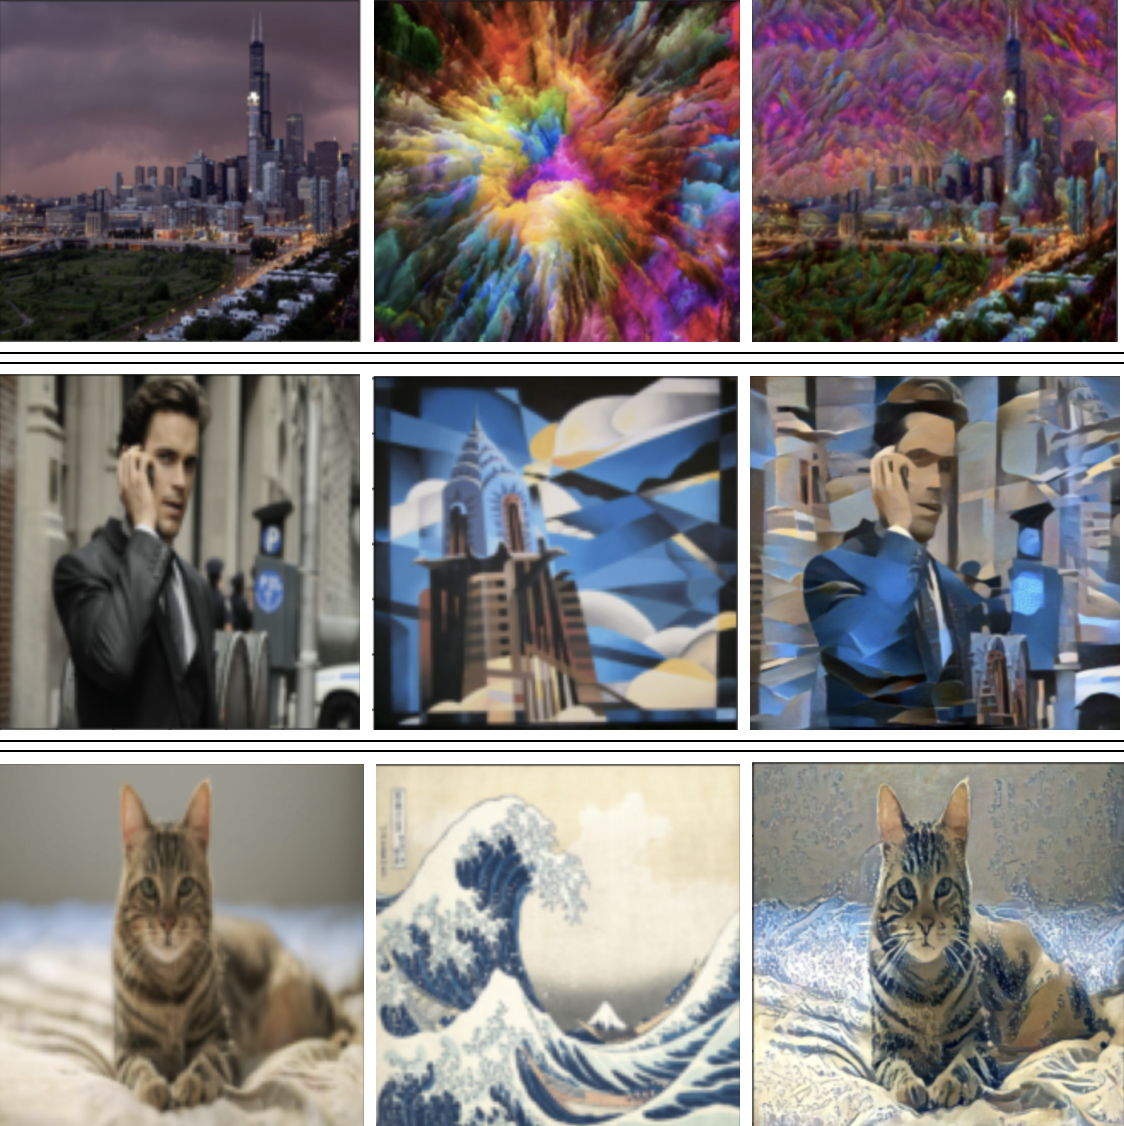
